# Weed Detection

## Preprocessing

In [1]:
!pip install tensorflow tensorflow-datasets matplotlib

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [3]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
print("Loading Deep Weeds dataset...")
ds, ds_info = tfds.load('deep_weeds', split='train', shuffle_files=True, with_info=True)

Loading Deep Weeds dataset...


In [5]:
class_names = ds_info.features['label'].names
print("Classes:", class_names)
print("Total examples:", ds_info.splits['train'].num_examples)

Classes: ['Chinee apple', 'Lantana', 'Parkinsonia', 'Parthenium', 'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake weed', 'Negative']
Total examples: 17509


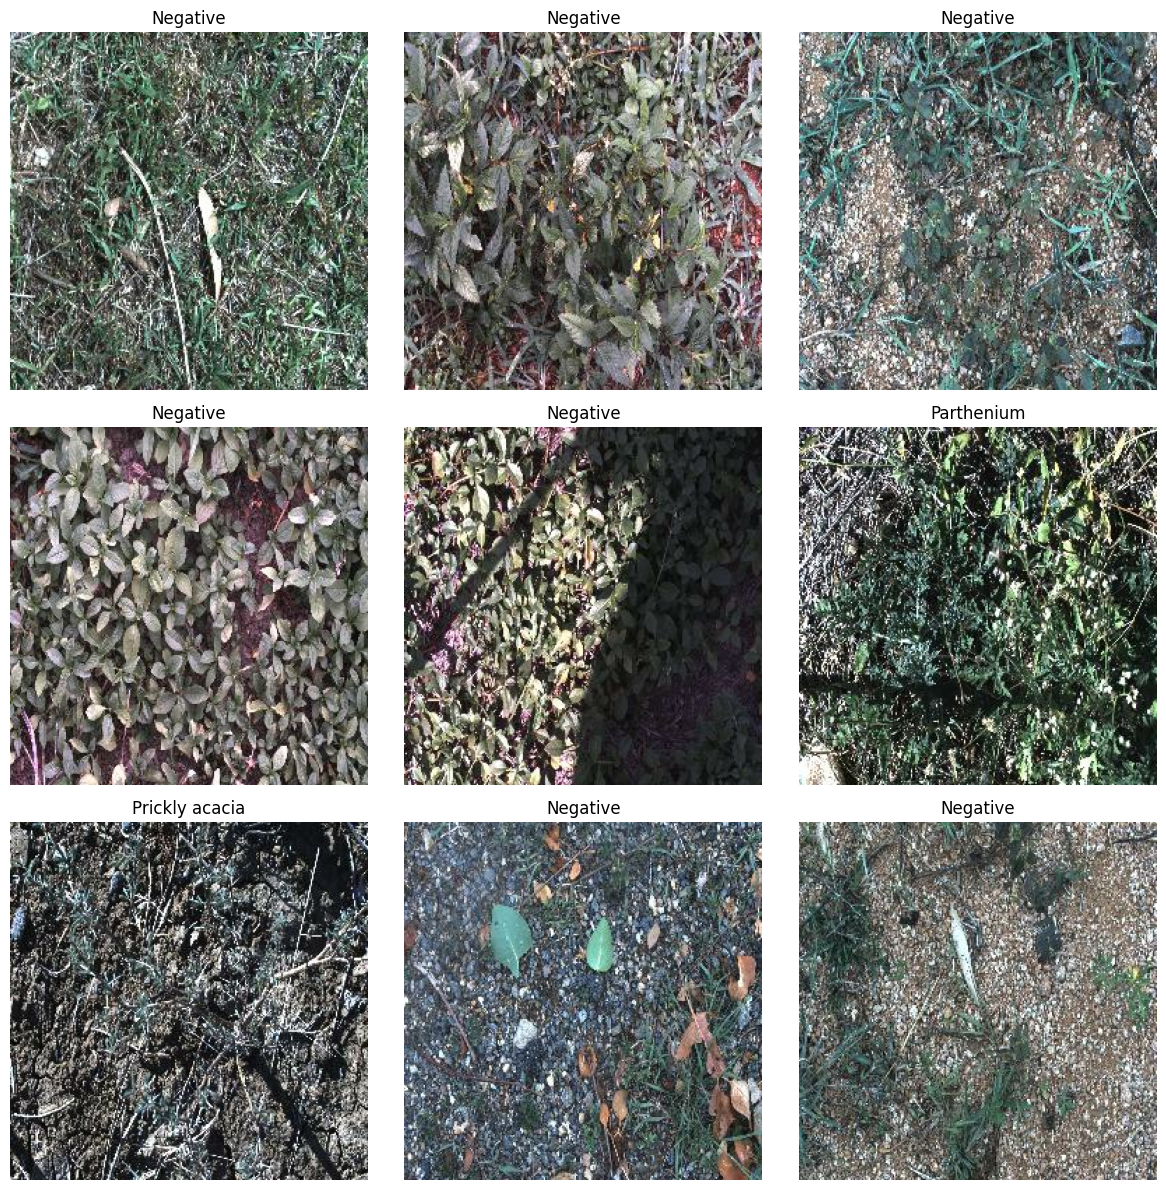

In [6]:
plt.figure(figsize=(12, 12))
for i, example in enumerate(ds.take(9)):
    image = example['image']
    label = example['label'].numpy()
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"{class_names[label]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
def preprocess(example):
    image = tf.image.resize(example['image'], [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    label = example['label']
    binary_label = tf.where(label == 8, 0, 1)
    return image, binary_label

In [8]:
BATCH_SIZE = 32
ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
class_counts = [0, 0]
for _, label in ds:
    class_counts[int(label.numpy())] += 1
print(f"Class distribution - Not Weed (0): {class_counts[0]}, Weed (1): {class_counts[1]}")

Class distribution - Not Weed (0): 9106, Weed (1): 8403


In [10]:
total = sum(class_counts)
class_weights = {0: total/(2*class_counts[0]), 1: total/(2*class_counts[1])}
print("Class weights:", class_weights)

Class weights: {0: 0.961399077531298, 1: 1.0418302987028443}


In [11]:
ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
total_batches = tf.data.experimental.cardinality(ds).numpy()
train_size = int(0.8 * total_batches)
val_size = total_batches - train_size

train_ds = ds.take(train_size)
val_ds = ds.skip(train_size)

print(f"Train batches: {train_size}, Validation batches: {val_size}")

Train batches: 438, Validation batches: 110


In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

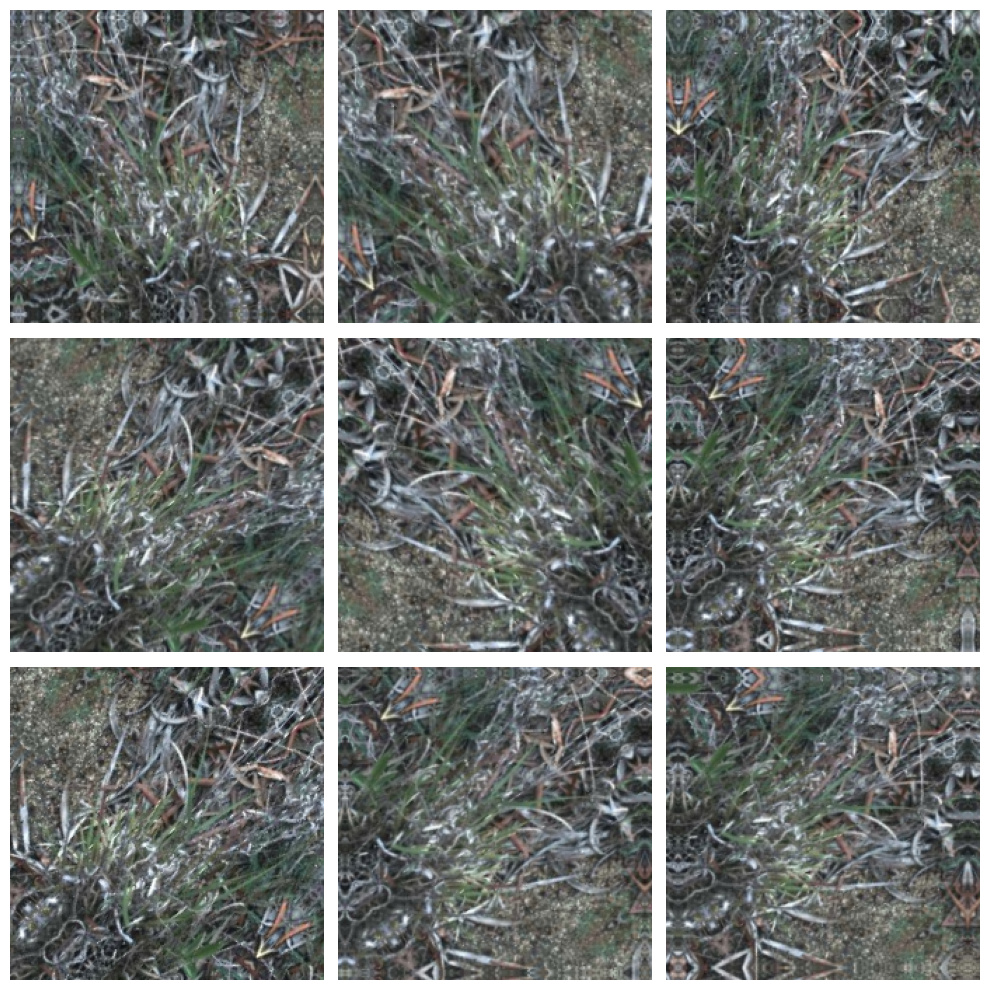

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy())
        plt.axis("off")
plt.tight_layout()
plt.show()

## Create Base Model

In [15]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

In [16]:
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [17]:
initial_lr = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [18]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model_initial.h5', monitor='val_accuracy', save_best_only=True
)

In [19]:
print("Phase 1: Training with frozen base model...")
history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=[tensorboard_callback, early_stopping, model_checkpoint]
)

Phase 1: Training with frozen base model...
Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7025 - auc: 0.7717 - loss: 0.5795

438/438 ━━━━━━━━━━━━━━━━━━━━ 64s 125ms/step - accuracy: 0.7026 - auc: 0.7718 - loss: 0.5793 - val_accuracy: 0.7615 - val_auc: 0.8745 - val_loss: 0.4805
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7981 - auc: 0.8759 - loss: 0.4410

438/438 ━━━━━━━━━━━━━━━━━━━━ 77s 118ms/step - accuracy: 0.7981 - auc: 0.8759 - loss: 0.4410 - val_accuracy: 0.8002 - val_auc: 0.8917 - val_loss: 0.4216
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 119ms/step - accuracy: 0.8065 - auc: 0.8913 - loss: 0.4147 - val_accuracy: 0.7899 - val_auc: 0.9107 - val_loss: 0.4273
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8121 - auc: 0.8995 - loss: 0.3983

438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 119ms/step - accuracy: 0.8121 - auc: 0.8995 - loss: 0.3983 - val_accuracy: 0.8251 - val_auc: 0.9181 - val_loss: 0.3776
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 118ms/step - accuracy: 0.8212 - auc: 0.9072 - loss: 0.3840 - val_accuracy: 0.7956 - val_auc: 0.9129 - val_loss: 0.4178
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 52s 117ms/step - accuracy: 0.8275 - auc: 0.9138 - loss: 0.3714 - val_accuracy: 0.8113 - val_auc: 0.9259 - val_loss: 0.3966
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8298 - auc: 0.9141 - loss: 0.3716

438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 118ms/step - accuracy: 0.8298 - auc: 0.9141 - loss: 0.3716 - val_accuracy: 0.8391 - val_auc: 0.9238 - val_loss: 0.3613
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 119ms/step - accuracy: 0.8402 - auc: 0.9198 - loss: 0.3597 - val_accuracy: 0.8131 - val_auc: 0.9248 - val_loss: 0.3992
Epoch 9/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - accuracy: 0.8438 - auc: 0.9234 - loss: 0.3517 - val_accuracy: 0.8239 - val_auc: 0.9299 - val_loss: 0.3722
Epoch 10/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 52s 117ms/step - accuracy: 0.8534 - auc: 0.9312 - loss: 0.3343 - val_accuracy: 0.8099 - val_auc: 0.9156 - val_loss: 0.4132


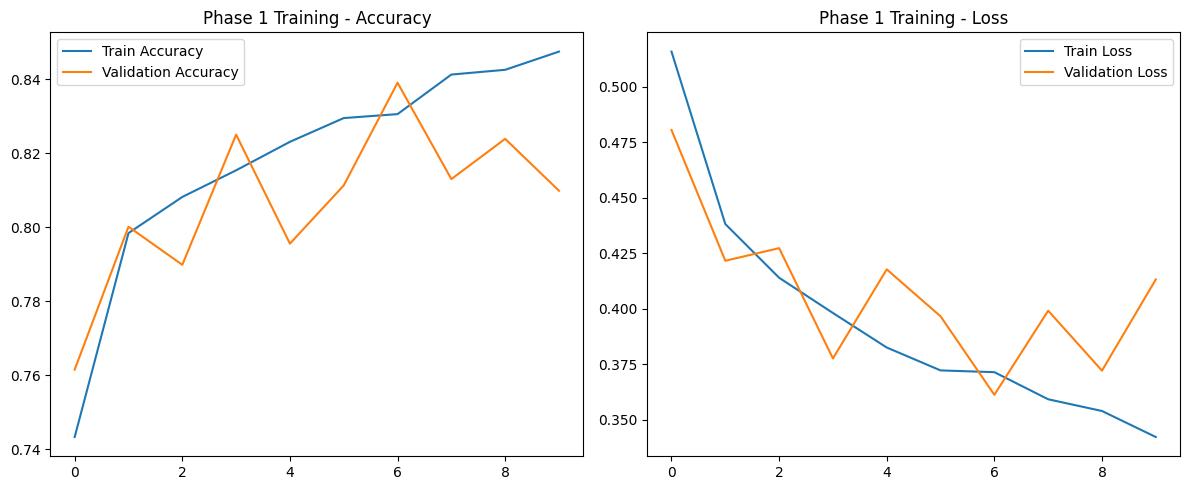

In [20]:
def plot_history(history, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_1, 'Phase 1 Training')

## Fine Tuning

Phase 2: Fine-tuning the model...
0: input_layer_1, Trainable: False
1: Conv1, Trainable: False
2: bn_Conv1, Trainable: False
3: Conv1_relu, Trainable: False
4: expanded_conv_depthwise, Trainable: False
5: expanded_conv_depthwise_BN, Trainable: False
6: expanded_conv_depthwise_relu, Trainable: False
7: expanded_conv_project, Trainable: False
8: expanded_conv_project_BN, Trainable: False
9: block_1_expand, Trainable: False
10: block_1_expand_BN, Trainable: False
11: block_1_expand_relu, Trainable: False
12: block_1_pad, Trainable: False
13: block_1_depthwise, Trainable: False
14: block_1_depthwise_BN, Trainable: False
15: block_1_depthwise_relu, Trainable: False
16: block_1_project, Trainable: False
17: block_1_project_BN, Trainable: False
18: block_2_expand, Trainable: False
19: block_2_expand_BN, Trainable: False
20: block_2_expand_relu, Trainable: False
21: block_2_depthwise, Trainable: False
22: block_2_depthwise_BN, Trainable: False
23: block_2_depthwise_relu, Trainable: False
24: 

438/438 ━━━━━━━━━━━━━━━━━━━━ 64s 125ms/step - accuracy: 0.8236 - auc: 0.9084 - loss: 0.3904 - val_accuracy: 0.8205 - val_auc: 0.9149 - val_loss: 0.3924 - learning_rate: 1.0000e-04
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8485 - auc: 0.9288 - loss: 0.3406

438/438 ━━━━━━━━━━━━━━━━━━━━ 80s 123ms/step - accuracy: 0.8485 - auc: 0.9288 - loss: 0.3406 - val_accuracy: 0.8457 - val_auc: 0.9343 - val_loss: 0.3349 - learning_rate: 1.0000e-04
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 54s 121ms/step - accuracy: 0.8535 - auc: 0.9352 - loss: 0.3244 - val_accuracy: 0.8445 - val_auc: 0.9405 - val_loss: 0.3379 - learning_rate: 1.0000e-04
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8652 - auc: 0.9407 - loss: 0.3101

438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 122ms/step - accuracy: 0.8651 - auc: 0.9407 - loss: 0.3101 - val_accuracy: 0.8574 - val_auc: 0.9429 - val_loss: 0.3320 - learning_rate: 1.0000e-04
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8680 - auc: 0.9456 - loss: 0.2986

438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 120ms/step - accuracy: 0.8680 - auc: 0.9456 - loss: 0.2987 - val_accuracy: 0.8577 - val_auc: 0.9433 - val_loss: 0.3264 - learning_rate: 1.0000e-04
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8742 - auc: 0.9500 - loss: 0.2860

438/438 ━━━━━━━━━━━━━━━━━━━━ 55s 123ms/step - accuracy: 0.8742 - auc: 0.9500 - loss: 0.2860 - val_accuracy: 0.8594 - val_auc: 0.9454 - val_loss: 0.3105 - learning_rate: 1.0000e-04
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 81s 121ms/step - accuracy: 0.8773 - auc: 0.9522 - loss: 0.2792 - val_accuracy: 0.8543 - val_auc: 0.9463 - val_loss: 0.3464 - learning_rate: 1.0000e-04
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8749 - auc: 0.9517 - loss: 0.2812

438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 121ms/step - accuracy: 0.8749 - auc: 0.9517 - loss: 0.2812 - val_accuracy: 0.8620 - val_auc: 0.9512 - val_loss: 0.3229 - learning_rate: 1.0000e-04
Epoch 9/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8867 - auc: 0.9568 - loss: 0.2674

438/438 ━━━━━━━━━━━━━━━━━━━━ 83s 122ms/step - accuracy: 0.8867 - auc: 0.9568 - loss: 0.2674 - val_accuracy: 0.8646 - val_auc: 0.9527 - val_loss: 0.3051 - learning_rate: 2.0000e-05
Epoch 10/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8874 - auc: 0.9568 - loss: 0.2664

438/438 ━━━━━━━━━━━━━━━━━━━━ 55s 123ms/step - accuracy: 0.8874 - auc: 0.9568 - loss: 0.2664 - val_accuracy: 0.8697 - val_auc: 0.9526 - val_loss: 0.2971 - learning_rate: 2.0000e-05
Epoch 11/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 55s 123ms/step - accuracy: 0.8909 - auc: 0.9612 - loss: 0.2528 - val_accuracy: 0.8672 - val_auc: 0.9504 - val_loss: 0.3034 - learning_rate: 2.0000e-05
Epoch 12/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 54s 120ms/step - accuracy: 0.8891 - auc: 0.9593 - loss: 0.2591 - val_accuracy: 0.8652 - val_auc: 0.9502 - val_loss: 0.3076 - learning_rate: 2.0000e-05
Epoch 13/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8924 - auc: 0.9607 - loss: 0.2541

438/438 ━━━━━━━━━━━━━━━━━━━━ 55s 123ms/step - accuracy: 0.8924 - auc: 0.9607 - loss: 0.2541 - val_accuracy: 0.8723 - val_auc: 0.9550 - val_loss: 0.2925 - learning_rate: 4.0000e-06
Epoch 14/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8976 - auc: 0.9645 - loss: 0.2418

438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 123ms/step - accuracy: 0.8976 - auc: 0.9645 - loss: 0.2418 - val_accuracy: 0.8732 - val_auc: 0.9533 - val_loss: 0.2985 - learning_rate: 4.0000e-06
Epoch 15/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 54s 122ms/step - accuracy: 0.8972 - auc: 0.9635 - loss: 0.2456 - val_accuracy: 0.8709 - val_auc: 0.9542 - val_loss: 0.2936 - learning_rate: 4.0000e-06
Epoch 16/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 121ms/step - accuracy: 0.8921 - auc: 0.9620 - loss: 0.2491 - val_accuracy: 0.8720 - val_auc: 0.9530 - val_loss: 0.2965 - learning_rate: 1.0000e-06


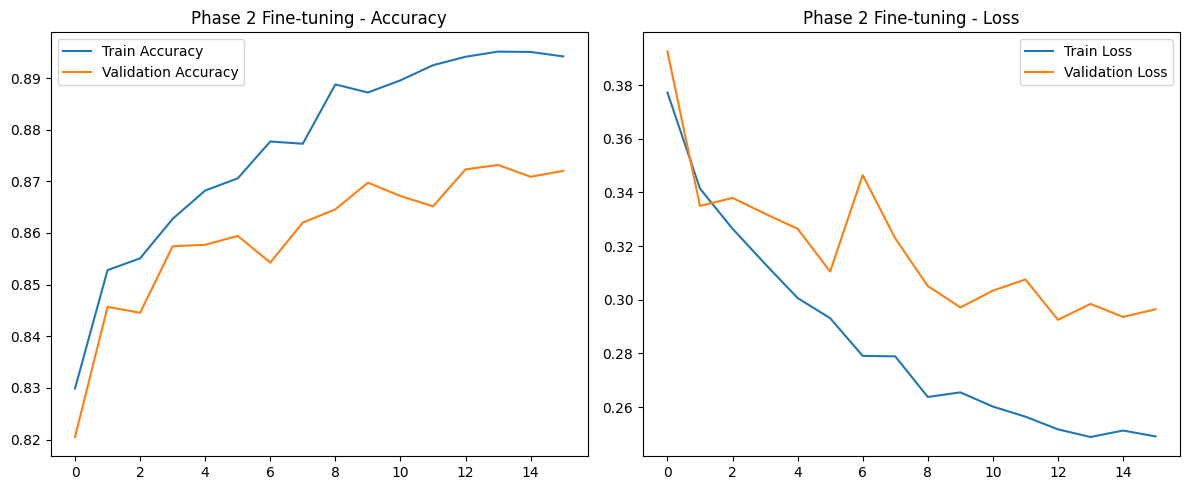

Evaluating final model...
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.8711 - auc: 0.9587 - loss: 0.2741


Validation Loss: 0.2972398102283478
Validation Accuracy: 0.8708845973014832
Validation AUC: 0.9535877704620361
Model saved as 'deepweeds_binary_final.h5'


In [21]:
base_model.trainable = True

fine_tune_at = len(base_model.layers) - 4
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

for i, layer in enumerate(base_model.layers):
    print(f"{i}: {layer.name}, Trainable: {layer.trainable}")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr/10),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

history_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[tensorboard_callback, early_stopping, reduce_lr,
               tf.keras.callbacks.ModelCheckpoint('best_model_finetuned.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True)]
)


plot_history(history_2, 'Phase 2 Fine-tuning')

print("Evaluating final model...")
eval_results = model.evaluate(val_ds)
print("Validation Loss:", eval_results[0])
print("Validation Accuracy:", eval_results[1])
print("Validation AUC:", eval_results[2])


model.save('deepweeds_binary_final.h5')
print("Model saved as 'deepweeds_binary_final.h5'")

## Display Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/st

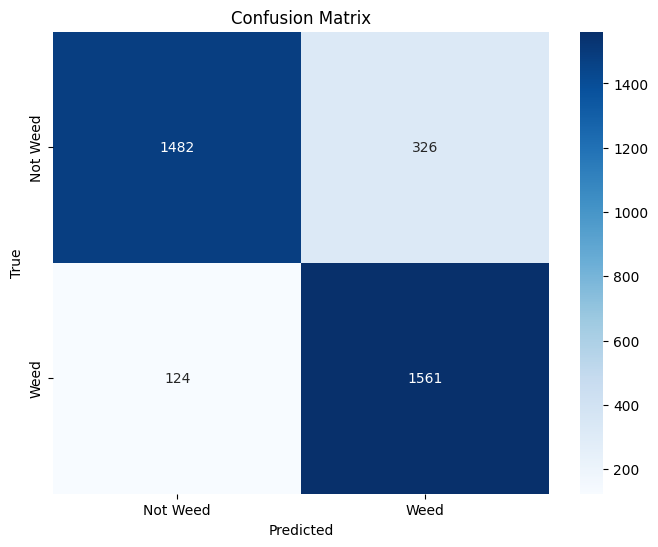

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend([1 if p > 0.5 else 0 for p in predictions])

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Weed', 'Weed'],
            yticklabels=['Not Weed', 'Weed'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [23]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Not Weed', 'Weed']))

Classification Report:
              precision    recall  f1-score   support

    Not Weed       0.92      0.82      0.87      1808
        Weed       0.83      0.93      0.87      1685

    accuracy                           0.87      3493
   macro avg       0.88      0.87      0.87      3493
weighted avg       0.88      0.87      0.87      3493



## Test on Single Image

In [24]:
def predict_image(model, img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    confidence = prediction if prediction > 0.5 else 1 - prediction
    result = "Weed" if prediction > 0.5 else "Not Weed"

    return result, confidence


In [29]:
result, confidence = predict_image(model, "caWeed.jpg")
print(f"Prediction: {result} with {confidence:.2%} confidence")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Prediction: Weed with 98.37% confidence
